In [5]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [6]:
# set up a linear fit
def linear(x, *p):
    a, b = p
    return a*x + b

def sinusoid(x, *p):
    a, b, c, d = p
    return a * np.cos(b*x-c) + d

def sinusoid_deriv(x, *p):
    a, b, c, d = p
    return -a * b * np.sin(b*x-c)

def expoential(x, *p):
    a, b, c = p
    return 

def chi_squared(x, fit, sig):
     return np.sum(np.square(x-fit)/np.square(sig))

def reduced_chi_squared(x, fit, sig, N, n):
    return chi_squared(x, fit, sig)/(N-n)

In [29]:
# find the +- chi squared values for fit params
def fit_param_uncerts(fit_function, fit_params, x_vals, y_vals, uncerts):
    orig_chi = chi_squared(y_vals, fit_function(x_vals, *fit_params), uncerts)
    print(orig_chi)
    print(len(x_vals)-len(fit_params))
    print(orig_chi/(len(x_vals)-len(fit_params)))
    out_params=list()
    for i in range(len(fit_params)):
        param=fit_params[i]
        change_change=abs(param*10)
        test_change=abs(param/10)
        avg_change=10 #placeholder
        last_avg_change=1000
        while abs(avg_change -1) > .01:
            fit_params_up=fit_params.copy()
            fit_params_down=fit_params.copy()
            fit_params_up[i]=fit_params[i]+test_change
            fit_params_down[i]=fit_params[i]-test_change

            #find chi squareds
            up_chi = chi_squared(y_vals, fit_function(x_vals, *fit_params_up), uncerts)
            down_chi = chi_squared(y_vals, fit_function(x_vals, *fit_params_down), uncerts)
            avg_change = (up_chi+down_chi-2*orig_chi)/2
            
           # print('Got avg change {} with test change {} and change change {} on param {}'.format(avg_change, test_change, change_change, param))
            
            #update for next run
            if avg_change > 1:
                test_change = min(abs(test_change-change_change), test_change)
            else:
                test_change = abs(test_change+change_change)
            if last_avg_change-1<0 != avg_change-1==0:
                change_change = min(change_change/(2), test_change/10)
            else:
                change_change = min(change_change*2, test_change/10)
                
        out_params.append(test_change)
    return out_params

In [9]:
calib = pd.read_table('/home/kal/jLab/optical_trapping/calibration_data/calib_20181031_1um1000Knacl_250.1fullx.txt', delimiter='\t', header=None)
calib.columns = 'x_volts y_volts x_strain y_strain'.split()


strain_data = calib['x_strain']
qpd_data = calib['x_volts']
# set up the bin sizes
bins = np.linspace(min(strain_data), max(strain_data), num_bins)
bin_means = np.asarray(bins + (min(strain_data)-max(strain_data))/(2*num_bins))[:-1]
# bin the data
digitized = np.digitize(strain_data, bins)
qpd_means = [np.mean(qpd_data[digitized == i]) for i in range(1, len(bins))]
qpd_errors = [scipy.stats.sem(qpd_data[digitized == i]) for i in range(1, len(bins))]

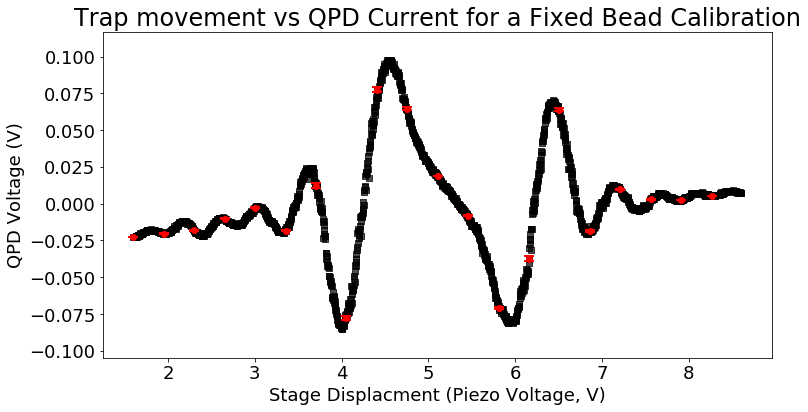

In [10]:
# plot the origonal and binned
bbox = dict(boxstyle="round", fc="0.95")

fig, ax = plt.subplots(1, figsize=(12, 6))

# plot the points
ax.scatter(bin_means, qpd_means, c='k', marker=',', alpha=0.7)
ax.errorbar(bin_means[0::100], qpd_means[0::100], yerr=qpd_errors[0::100], fmt='.', c='red', ecolor='red', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

# add labesl
ax.set_title('Trap movement vs QPD Current for a Fixed Bead Calibration')
ax.set_xlabel('Stage Displacment (Piezo Voltage, V)')
ax.set_ylabel('QPD Voltage (V)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

In [11]:
# get the data for calibration
# data tables have the following format:
# first column [0] is stage x strain gauge voltage
# second column [1] is stage y strain gauge voltage
# third column [2] is QPD x voltage
# fourth column [3] is QPD y voltage

# calibration

file_path = '/home/kal/jLab/optical_trapping/calibration_data/'
file_names = [f for f in os.listdir(file_path) if not 'Settings' in f]
file_names = [f for f in file_names if not 'full' in f]

xys = [0 if f.split('.')[-2][-1] == 'x' else 1 for f in file_names]
xys = np.asarray(xys).flatten()
# test one out

file_name = os.path.join(file_path, file_names[0])
calib = pd.read_table(file_name, delimiter='\t', header=None)
calib.columns = 'x_volts y_volts x_strain y_strain'.split()
calib.head()

,x_volts,y_volts,x_strain,y_strain
0,0.000879,-0.002735,4.23744,5.08805
1,0.000550,-0.002735,4.23613,5.08772
2,0.000879,-0.002407,4.23514,5.08706
3,0.000879,-0.002407,4.23448,5.08706
4,0.000879,-0.003064,4.23317,5.08641




  0%|          | 0/20 [00:00<?, ?it/s]

calib_20181031_1um1000Knacl_100.1x.txt


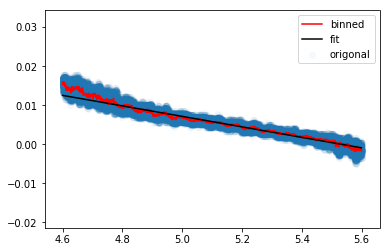



  5%|▌         | 1/20 [00:03<01:08,  3.61s/it]

1586.0034336954373
0.7941930063572545
calib_20181031_1um1000Knacl_100.1y.txt


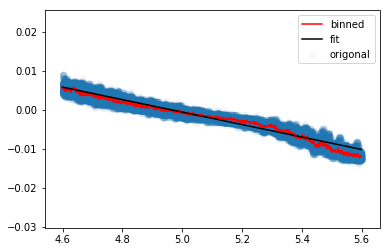



 10%|█         | 2/20 [00:07<01:05,  3.67s/it]

3747.6286518696916
1.8766292698396052
calib_20181031_1um1000Knacl_149.9x.txt


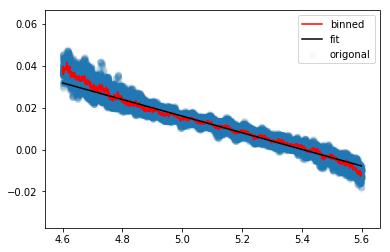



 15%|█▌        | 3/20 [00:10<00:58,  3.43s/it]

1546.386193285652
0.7743546285857046
calib_20181031_1um1000Knacl_149.9y.txt


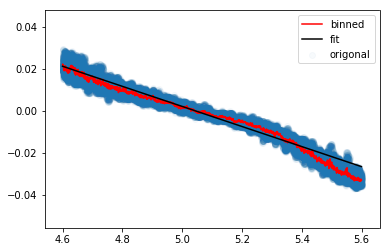



 20%|██        | 4/20 [00:15<01:01,  3.86s/it]

4547.510418730179
2.27717096581381
calib_20181031_1um1000Knacl_200.2x.txt


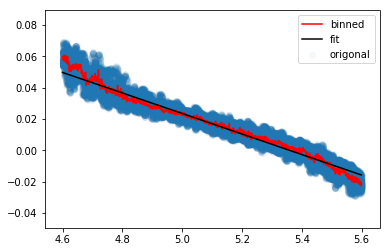



 25%|██▌       | 5/20 [00:18<00:55,  3.68s/it]

1312.5736780180946
0.6572727481312441
calib_20181031_1um1000Knacl_200.2y.txt


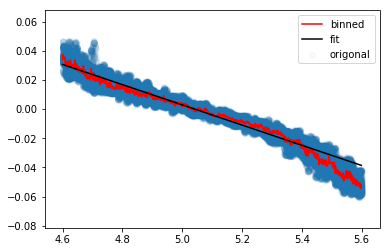



 30%|███       | 6/20 [00:21<00:50,  3.64s/it]

3108.9988674822107
1.55683468576976
calib_20181031_1um1000Knacl_250.1x.txt


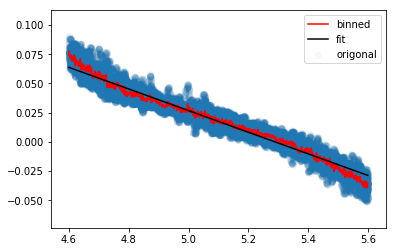

1286.7893591189177
0.6443612213915462




 35%|███▌      | 7/20 [00:27<00:53,  4.09s/it]

calib_20181031_1um1000Knacl_250.1y.txt


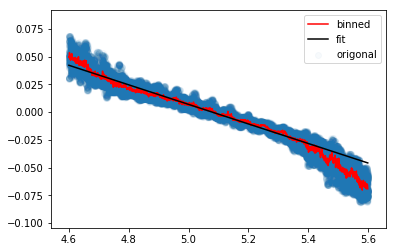



 40%|████      | 8/20 [00:32<00:53,  4.43s/it]

2445.2395365079724
1.2244564529333863
calib_20181031_1um1000Knacl_299.9x.txt


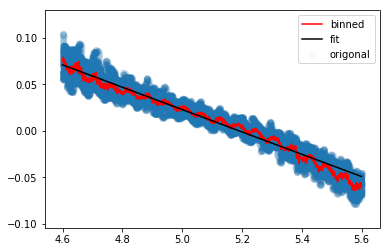



 45%|████▌     | 9/20 [00:35<00:45,  4.15s/it]

1843.8662584871702
0.9233181064031899
calib_20181031_1um1000Knacl_299.9y.txt


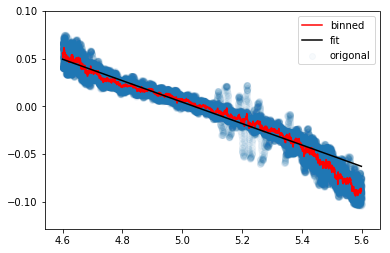

3737.392102960356
1.8715033064398379




 50%|█████     | 10/20 [00:39<00:39,  3.99s/it]

calib_20181031_1um1000Knacl_350.0x.txt


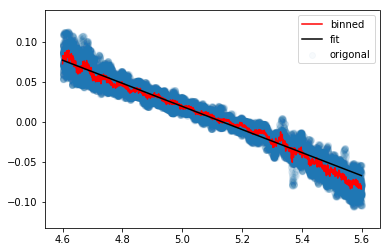



 55%|█████▌    | 11/20 [00:44<00:38,  4.30s/it]

1343.0663839511285
0.6725420049830388
calib_20181031_1um1000Knacl_350.0y.txt


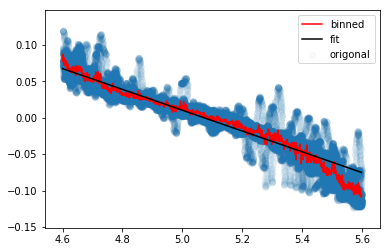

1997.4148047543504
1.0002077139480974


 60%|██████    | 12/20 [00:49<00:35,  4.45s/it]

calib_20181031_1um1000Knacl_400.3x.txt


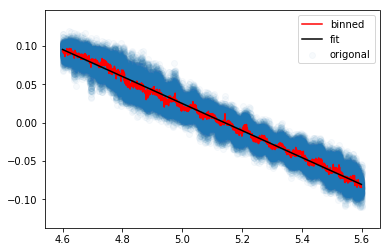



 65%|██████▌   | 13/20 [00:52<00:28,  4.11s/it]

397.70695919168463
0.19915220790770388
calib_20181031_1um1000Knacl_400.3y.txt


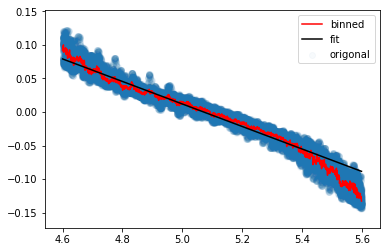



 70%|███████   | 14/20 [00:55<00:22,  3.80s/it]

3064.5432723356253
1.5345734964124313
calib_20181031_1um1000Knacl_450.4x.txt


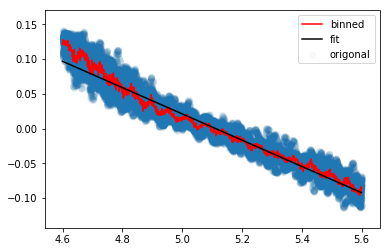



 75%|███████▌  | 15/20 [00:59<00:19,  3.84s/it]

1829.138627950069
0.9159432288182618
calib_20181031_1um1000Knacl_450.4y.txt


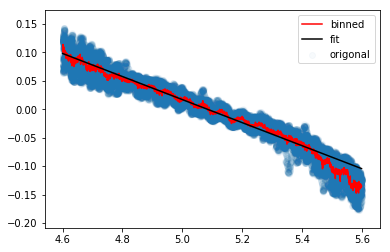

1450.1054119150806
0.726141918835794




 80%|████████  | 16/20 [01:05<00:17,  4.33s/it]

calib_20181031_1um1000Knacl_495.3x.txt


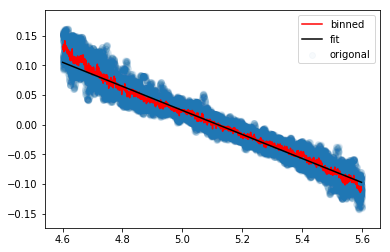

675.9184216698741
0.33846691120173966




 85%|████████▌ | 17/20 [01:09<00:13,  4.40s/it]

calib_20181031_1um1000Knacl_495.3y.txt


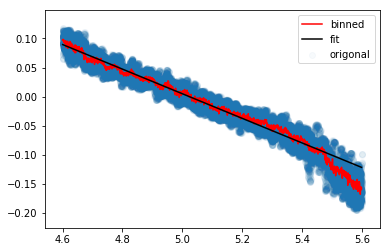



 90%|█████████ | 18/20 [01:13<00:08,  4.31s/it]

1500.9337366851669
0.7515942597321817
calib_20181031_1um1000Knacl_75.7x.txt


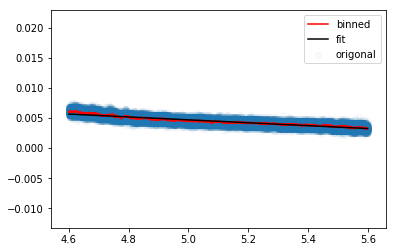



 95%|█████████▌| 19/20 [01:17<00:04,  4.25s/it]

531.944296508141
0.2663717058127897
calib_20181031_1um1000Knacl_75.7y.txt


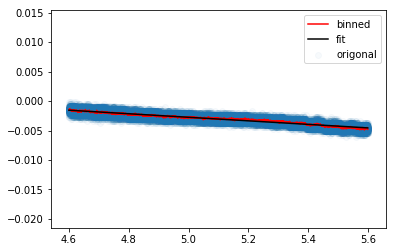



100%|██████████| 20/20 [01:21<00:00,  4.19s/it]



422.59216401868827
0.21161350226273823


In [28]:
# bin to get errors
voltages= list()
slopes=list()
intercepts=list()
slope_errors=list()
intercept_errors=list()
num_bins=2000
low_cut=4.6
high_cut=5.6
mid = (high_cut+low_cut)/2
diff = (high_cut-low_cut)/2

for file_name in tqdm(file_names):
    print(file_name)
    calib = pd.read_table(os.path.join(file_path, file_name), delimiter='\t', header=None)
    calib.columns = 'x_volts y_volts x_strain y_strain'.split()

    # get specific dataset
    voltage = file_name.split('_')[-1].split('x')[0].split('y')[0]
    if file_name.split('.')[-2][-1] == 'x':
        strain_data = calib[(abs(calib['x_strain'] - mid) <diff)]['x_strain']
        qpd_data = calib[(abs(calib['x_strain'] - mid) <diff)]['x_volts']
    else:
        strain_data = calib[(abs(calib['y_strain'] - mid) <diff)]['y_strain']
        qpd_data = calib[(abs(calib['y_strain'] - mid) <diff)]['y_volts']

    # set up the bin sizes
    bins = np.linspace(min(strain_data), max(strain_data), num_bins)
    bin_means = np.asarray(bins + (min(strain_data)-max(strain_data))/(2*num_bins))[:-1]

    # bin the data
    digitized = np.digitize(strain_data, bins)

    qpd_means = [np.mean(qpd_data[digitized == i]) for i in range(1, len(bins))]
    qpd_errors = [scipy.stats.sem(qpd_data[digitized == i])*5 for i in range(1, len(bins))]

    # plot the origonal and binned
    plt.scatter(strain_data, qpd_data, label='origonal', alpha=0.03)
    plt.plot(bin_means, qpd_means, 'r', label='binned')

    # curve fit
    # p0 is the initial guess for the fitting coefficients
    p0 = [-10, 10]
    popt, pcov = curve_fit(linear, bin_means, qpd_means, p0=p0, sigma=qpd_errors)
    # plot the curve fit
    plt.plot(bin_means, linear(bin_means, *popt), 'k', label='fit')
    plt.legend()
    plt.show()
    
    param_errors = fit_param_uncerts(linear, popt, bin_means, qpd_means, qpd_errors)
    slope_errors.append(param_errors[0])
    intercept_errors.append(param_errors[1])    

    # add to the lists of params
    voltages.append(voltage)
    slopes.append(popt[0])
    intercepts.append(popt[1])

In [57]:
# fit the qpd-distancec at differnet voltages
# we give it strain, it gives out a qpd
# so slope is 1/slpe and int is - int for other way
calibrations = pd.DataFrame({'voltage':[float(v) for v in voltages], 'intercept':intercepts, 'slope':slopes, 'xy':xys, 'serr':[400*s for s in slope_errors], 'ierr':intercept_errors})
calibrations.head()

,ierr,intercept,serr,slope,voltage,xy
0,0.000011,0.074297,0.001041,-0.013427,100.1,0
1,0.000012,0.079147,0.001135,-0.015953,100.1,1
2,0.000031,0.213976,0.002388,-0.039611,149.9,0
3,0.000032,0.241610,0.002547,-0.047892,149.9,1
4,0.000053,0.350963,0.005075,-0.065492,200.2,0


In [61]:
# fit the qpd-distancec at differnet voltages
# we give it qpd, it gives out a strain
# so slope is 1/slpe and int is - int
p0=[10, 0]
y_calib, pcov = curve_fit(linear, calibrations[calibrations['xy'] == 1]['voltage'], calibrations[calibrations['xy'] == 1]['slope'], sigma=calibrations[calibrations['xy'] == 1]['serr'], p0=p0)
x_calib, pcov = curve_fit(linear, calibrations[calibrations['xy'] == 0]['voltage'], calibrations[calibrations['xy'] == 0]['slope'], sigma=calibrations[calibrations['xy'] == 0]['serr'], p0=p0)

x_calib_errors = fit_param_uncerts(linear, x_calib,calibrations[calibrations['xy'] == 0]['voltage'], calibrations[calibrations['xy'] == 0]['slope'], calibrations[calibrations['xy'] == 0]['serr'])
y_calib_errors = fit_param_uncerts(linear, x_calib,calibrations[calibrations['xy'] == 1]['voltage'], calibrations[calibrations['xy'] == 1]['slope'], calibrations[calibrations['xy'] == 1]['serr'])

2.8917342703555695
8
0.3614667837944462
16.620689638768784
8
2.077586204846098


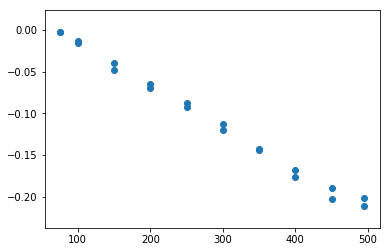

In [62]:
plt.scatter(calibrations['voltage'], calibrations['slope'])
plt.show()

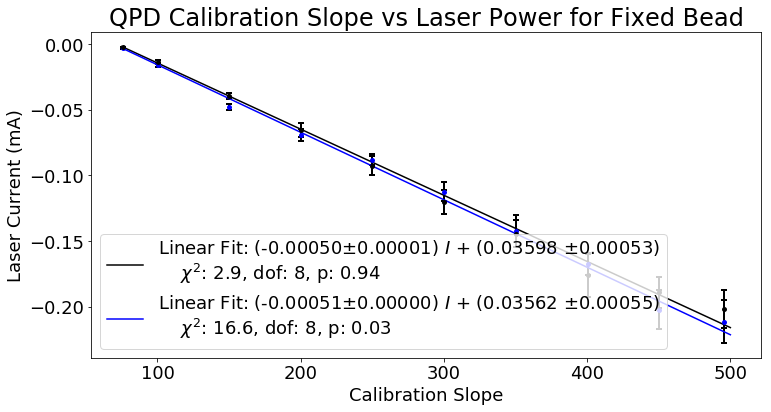

In [69]:
# plot the points
fig, ax = plt.subplots(1, figsize=(12, 6))


x_fit_label = 'Linear Fit: ({0:1.5f}$ \pm ${2:.5f}) $I$ + ({1:1.5f} $ \pm ${3:.5f})'.format(*x_calib, *x_calib_errors) 
x_fit_label  = x_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(2.89173, 8, 0.94)

y_fit_label = 'Linear Fit: ({0:1.5f}$ \pm ${2:.5f}) $I$ + ({1:1.5f} $ \pm ${3:.5f})'.format(*y_calib, *y_calib_errors) 
y_fit_label  = y_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(16.62, 8, 0.034)

# add labesl
ax.set_title('QPD Calibration Slope vs Laser Power for Fixed Bead')
ax.set_xlabel('Calibration Slope')
ax.set_ylabel('Laser Current (mA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

ax.errorbar(calibrations[calibrations['xy'] == 1]['voltage'], calibrations[calibrations['xy'] == 1]['slope'], yerr=calibrations[calibrations['xy'] == 1]['serr'], 
            c='b', fmt='.', capsize=3, elinewidth=2, markeredgewidth=2, ecolor='black', label=None)
ax.errorbar(calibrations[calibrations['xy'] == 0]['voltage'], calibrations[calibrations['xy'] == 0]['slope'], yerr=calibrations[calibrations['xy'] == 0]['serr'], 
            c='k', fmt='.', capsize=3, elinewidth=2, markeredgewidth=2, ecolor='black', label=None)

test_calibs = np.linspace(75, 500, 1000)
ax.plot(test_calibs, linear(test_calibs, *x_calib), c='k', label=x_fit_label)
ax.plot(test_calibs, linear(test_calibs, *y_calib), c='b', label=y_fit_label)

plt.legend(fontsize=18)


for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)



In [70]:
# do the trap stiffness as a function of voltage

file_path = '/home/kal/jLab/optical_trapping/equipartition_data/'
file_names = [f for f in os.listdir(file_path) if not 'Settings' in f]
print(file_names)

['psd_20181105_1um1000Kdi_100.3.txt', 'psd_20181105_1um1000Kdi_100.8.txt', 'psd_20181105_1um1000Kdi_149.8.txt', 'psd_20181105_1um1000Kdi_150.3.txt', 'psd_20181105_1um1000Kdi_199.9.txt', 'psd_20181105_1um1000Kdi_200.1.txt', 'psd_20181105_1um1000Kdi_250.0.txt', 'psd_20181105_1um1000Kdi_250.2.txt', 'psd_20181105_1um1000Kdi_299.4.txt', 'psd_20181105_1um1000Kdi_300.8.txt', 'psd_20181105_1um1000Kdi_350.6.txt', 'psd_20181105_1um1000Kdi_350.8.txt', 'psd_20181105_1um1000Kdi_400.1.txt', 'psd_20181105_1um1000Kdi_400.3.txt', 'psd_20181105_1um1000Kdi_450.1.txt', 'psd_20181105_1um1000Kdi_450.2.txt', 'psd_20181105_1um1000Kdi_495.4.txt', 'psd_20181105_1um1000Kdi_496.5.txt']


In [76]:
# bin to get errors
voltages = list()
variences = list()
var_error=list()
stage_var=list()

for file_name in tqdm(file_names):
    eqip = pd.read_table(os.path.join(file_path, file_name), delimiter='\t', header=None)
    eqip.columns = 'x_volts y_volts x_strain y_strain'.split()
    
    # get specific dataset
    voltage = float(file_name.split('_')[-1].split('.txt')[0])
    # calibrated slope at this voltage
    x_slope = linear(voltage, *x_calib)
    x_slope_up = linear(voltage, x_calib[0]+x_calib_errors[0], x_calib[1])
    x_slope_down = linear(voltage, x_calib[0]-x_calib_errors[0], x_calib[1])
    y_slope = linear(voltage,  *y_calib)
    y_slope_up = linear(voltage, y_calib[0]+y_calib_errors[0], y_calib[1])
    y_slope_down = linear(voltage, y_calib[0]-y_calib_errors[0], y_calib[1])
    
    # get the r values in strain units
    rs=list()
    rs_up=list()
    rs_down=list()
    rs.append(1/x_slope*(eqip['x_volts']-np.average(eqip['x_volts'])))
    rs.append(1/y_slope*(eqip['y_volts']-np.average(eqip['y_volts'])))
    rs_up.append(1/x_slope_up*(eqip['x_volts']-np.average(eqip['x_volts'])))
    rs_up.append(1/y_slope_up*(eqip['y_volts']-np.average(eqip['y_volts'])))
    rs_down.append(1/x_slope_down*(eqip['x_volts']-np.average(eqip['x_volts'])))
    rs_down.append(1/y_slope_down*(eqip['y_volts']-np.average(eqip['y_volts'])))
    rs = np.asarray(rs).flatten()
    rs_down = np.asarray(rs_down).flatten()
    rs_up = np.asarray(rs_up).flatten()
  
    #get the varience
    variences.append(np.var(rs))
    # get the voltage
    voltages.append(float(voltage))
    
    # error from varience in slope
    var_error.append((np.var(rs_up)-np.var(rs_down))/2)
    
    # varience in stage position
    stage_var.append((np.var(eqip['x_strain']) + np.var(eqip['y_strain']))/2)



  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:04,  3.67it/s]

 11%|█         | 2/18 [00:00<00:04,  3.28it/s]

 17%|█▋        | 3/18 [00:00<00:04,  3.18it/s]

 22%|██▏       | 4/18 [00:01<00:04,  3.16it/s]

 28%|██▊       | 5/18 [00:01<00:03,  3.25it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.12it/s]

 39%|███▉      | 7/18 [00:02<00:03,  3.17it/s]

 44%|████▍     | 8/18 [00:02<00:03,  3.26it/s]

 50%|█████     | 9/18 [00:02<00:02,  3.37it/s]

 56%|█████▌    | 10/18 [00:03<00:02,  3.33it/s]

 61%|██████    | 11/18 [00:03<00:02,  3.44it/s]

 67%|██████▋   | 12/18 [00:03<00:01,  3.52it/s]

 72%|███████▏  | 13/18 [00:03<00:01,  3.54it/s]

 78%|███████▊  | 14/18 [00:04<00:01,  3.35it/s]

 83%|████████▎ | 15/18 [00:04<00:00,  3.37it/s]

 89%|████████▉ | 16/18 [00:04<00:00,  3.49it/s]

 94%|█████████▍| 17/18 [00:05<00:00,  3.50it/s]

100%|██████████| 18/18 [00:05<00:00,  3.40it/s]



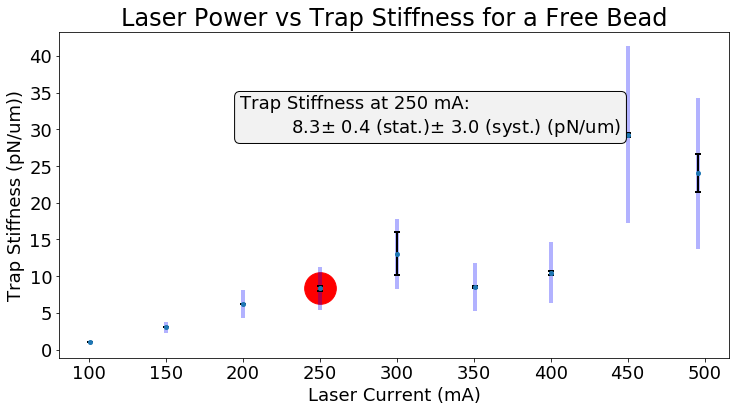

[0.00196762]


In [105]:
# error in stiffness from varience in slope? 

# set up the combined data sizes
new_vars=np.average(np.asarray(variences).reshape(-1, 2), axis=1)
var_error_2=.42/new_vars * new_vars/np.var(np.asarray(variences).reshape(-1, 2), axis=1)/np.sqrt(2)/10000
new_voltages=np.average(np.asarray(voltages).reshape(-1, 2), axis=1)
new_stage_var = np.average(np.asarray(stage_var).reshape(-1, 2), axis=1)

var_error_new = .42/new_vars * new_vars/np.average(np.asarray(var_error).reshape(-1, 2), axis=1)/100

fig, ax = plt.subplots(1, figsize=(12, 6))

# add labels
ax.set_title('Laser Power vs Trap Stiffness for a Free Bead')
ax.set_xlabel('Laser Current (mA)')
ax.set_ylabel('Trap Stiffness (pN/um))')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

ax.errorbar(new_voltages, .42/new_vars, yerr=var_error_new, fmt='.', capsize=0, elinewidth=4, markeredgewidth=2, ecolor='blue', alpha=0.3)
ax.errorbar(new_voltages, .42/new_vars, yerr=var_error_2, fmt='.', capsize=3, elinewidth=2, markeredgewidth=2, ecolor='black')

plt.scatter(250, .42/new_vars[3], marker='o', s=1000, c='r')


ax.annotate('Trap Stiffness at 250 mA: \n\t {:.1f}'.format(.42/new_vars[3]) + r'$ \pm $' + ' {:.1f} (stat.)'.format(var_error_2[3]) + r'$ \pm $' + ' {:.1f} (syst.) (pN/um)'.format(var_error_new[3]), 
            xy=(.27, .8), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)

plt.show()

print(np.sqrt(new_stage_var[[abs(v-250)<5 for v in new_voltages]]))

In [99]:
# get the stokes drag
file_path = '/home/kal/jLab/optical_trapping/stokes_data/'
file_names = [f for f in os.listdir(file_path) if not 'Settings' in f]
#file_names = [file_names[0]]
print(file_names)

['stokes_20181105_1um1000Kdi_.5_3_x.txt', 'stokes_20181105_1um1000Kdi_.5_3_y.txt', 'stokes_20181105_1um1000Kdi_.5_5_x.txt', 'stokes_20181105_1um1000Kdi_.5_5_y.txt', 'stokes_20181105_1um1000Kdi_1_3_x.txt', 'stokes_20181105_1um1000Kdi_1_3_y.txt', 'stokes_20181105_1um1000Kdi_1_5_x.txt', 'stokes_20181105_1um1000Kdi_1_5_y.txt', 'stokes_20181105_1um1000Kdi_2_3_x.txt', 'stokes_20181105_1um1000Kdi_2_3_y.txt', 'stokes_20181105_1um1000Kdi_2_5_x.txt', 'stokes_20181105_1um1000Kdi_2_5_y.txt']


stokes_20181105_1um1000Kdi_.5_3_x.txt
[0.15441092769999987, 0.0018855072, -5.26514, 5.1110590723]
[ 1.48531530e-01  1.88550720e-03 -6.33517400e+00  5.11124963e+00]


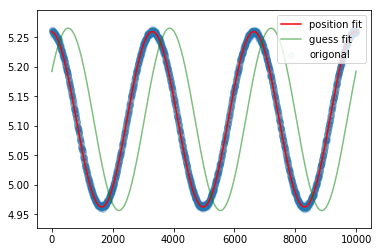

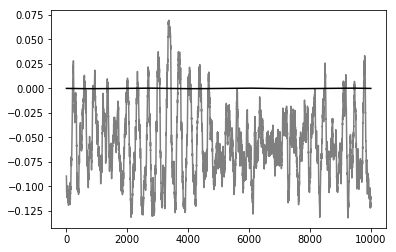

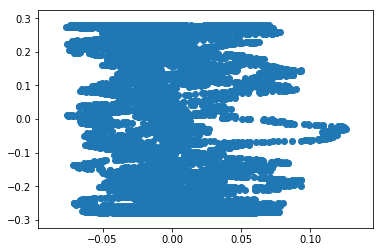


stokes_20181105_1um1000Kdi_.5_3_y.txt
[0.1608615474999997, 0.0018855072, -5.24378, 5.0852184525]
[ 1.53894711e-01  1.88443796e-03 -3.84551342e+00  5.08520743e+00]


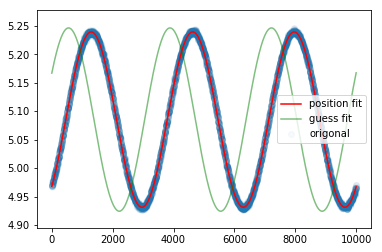

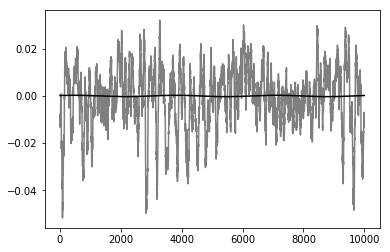

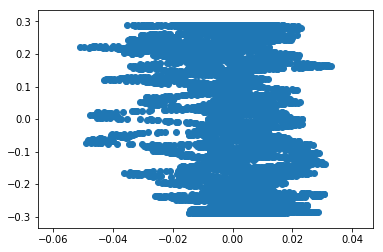


stokes_20181105_1um1000Kdi_.5_5_x.txt
[0.09361115260000119, 0.0018855072, -5.2037, 5.112388847399999]
[ 8.59832551e-02  3.14206856e-03 -1.57158857e+00  5.11230652e+00]


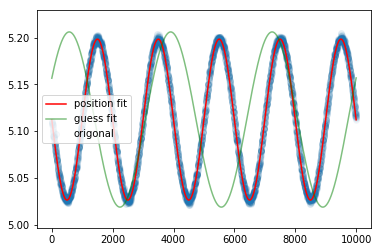

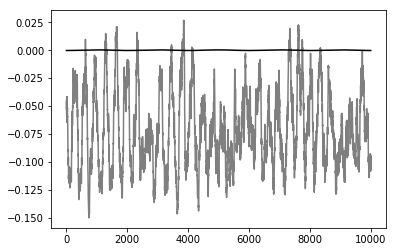

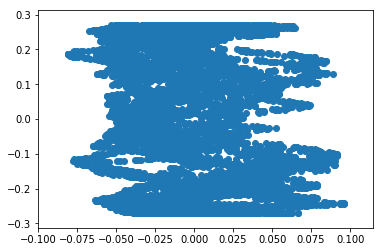


stokes_20181105_1um1000Kdi_.5_5_y.txt
[0.1599809066000022, 0.0018855072, -5.24345, 5.085769093399998]
[ 1.53616430e-01  1.88457506e-03 -5.19586385e+00  5.08629950e+00]


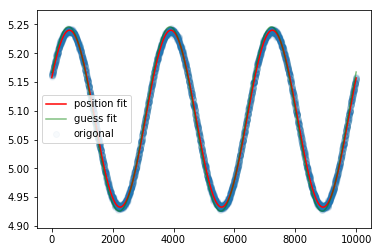

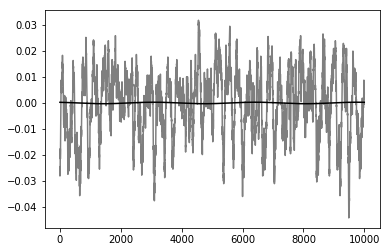

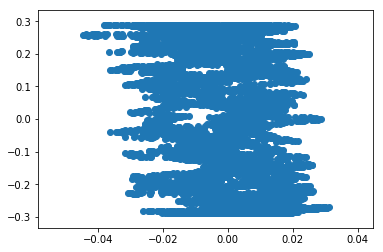


stokes_20181105_1um1000Kdi_1_3_x.txt
[0.3093008775000001, 0.0018855072, -5.4189, 5.1095991225]
[-3.03844697e-01  1.88493521e-03 -5.81477970e+00  5.10967039e+00]


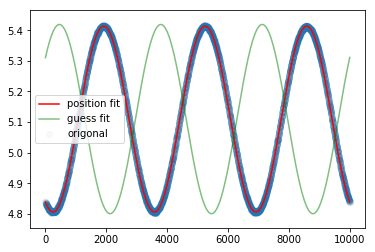

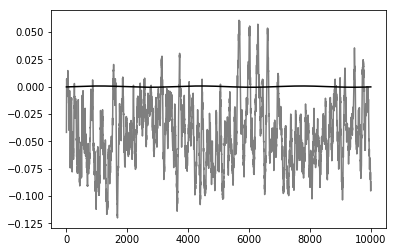

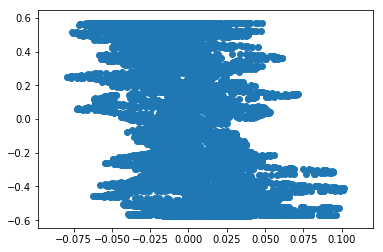


stokes_20181105_1um1000Kdi_1_3_y.txt
[0.32080257069999973, 0.0018855072, -5.40313, 5.0846274293]
[-3.14224621e-01  1.88549830e-03 -4.44749954e+00  5.08466028e+00]


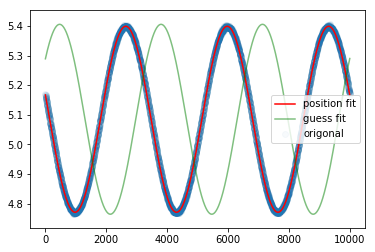

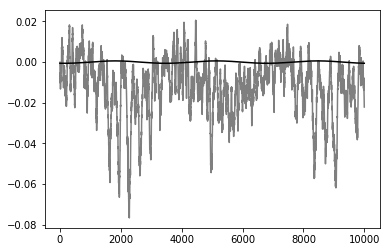

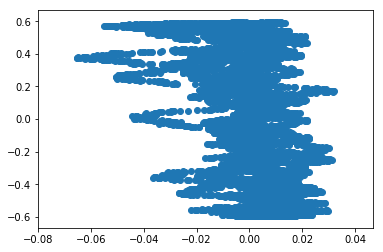


stokes_20181105_1um1000Kdi_1_5_x.txt
[0.18185017280000082, 0.0018855072, -5.28846, 5.1098998272]
[ 1.75462891e-01  3.14192348e-03 -2.18410752e+00  5.10992958e+00]


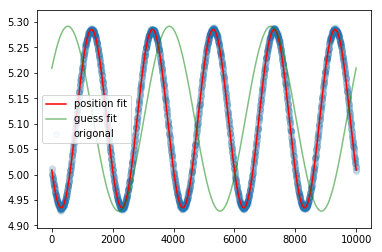

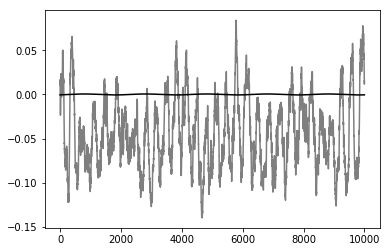

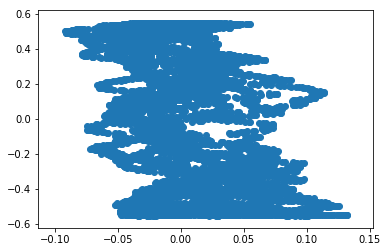


stokes_20181105_1um1000Kdi_1_5_y.txt
[0.1916383828999999, 0.0018855072, -5.27269, 5.0836816171]
[ 1.83804403e-01  3.14186182e-03 -2.17508842e+00  5.08349834e+00]


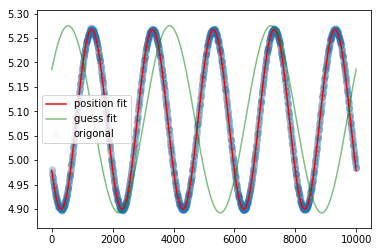

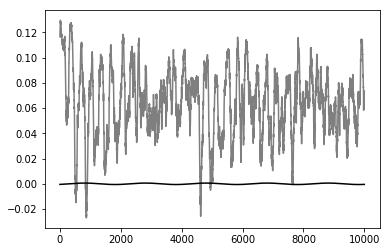

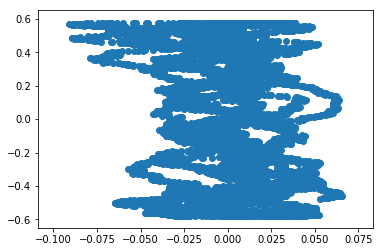


stokes_20181105_1um1000Kdi_2_3_x.txt
[0.6470990918000004, 0.0018855072, -5.75402, 5.1102009081999995]
[-6.43308181e-01  1.88519882e-03 -6.42192461e+00  5.11031811e+00]


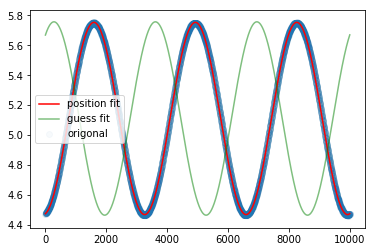

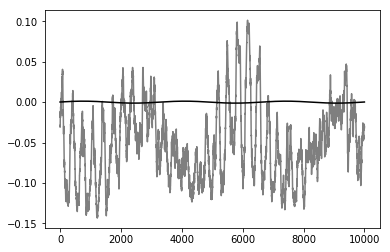

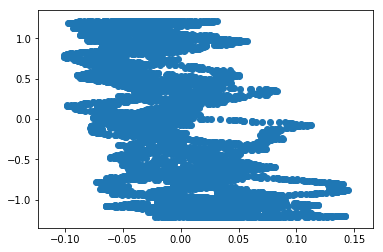


stokes_20181105_1um1000Kdi_2_3_y.txt
[0.6762822645999993, 0.0018855072, -5.7596, 5.0833177354000005]
[ 6.73393964e-01  1.88578137e-03 -3.80184136e+00  5.08298704e+00]


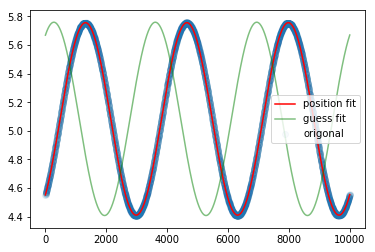

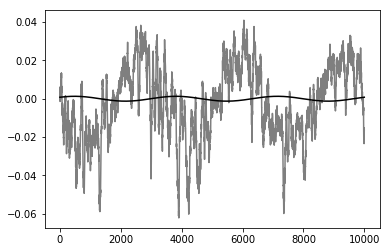

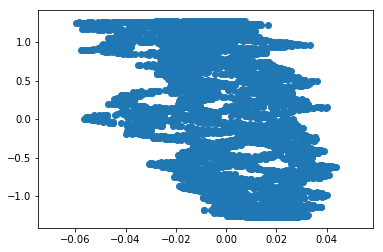


stokes_20181105_1um1000Kdi_2_5_x.txt
[0.3703313708999989, 0.0018855072, -5.47771, 5.1103286291000005]
[ 3.64582889e-01  3.14146752e-03 -2.19152083e+00  5.11032755e+00]


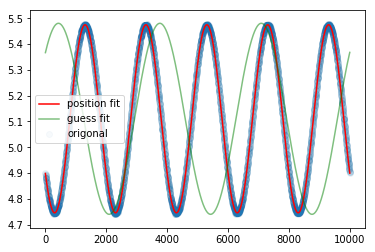

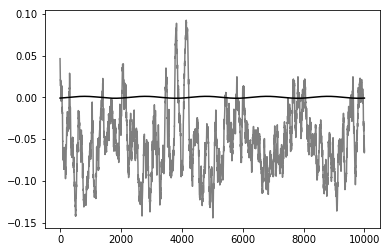

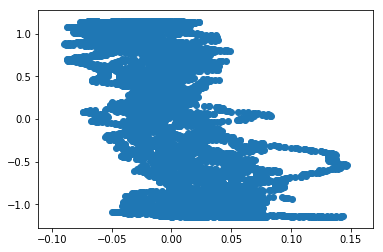


stokes_20181105_1um1000Kdi_2_5_y.txt
[0.38799336920000016, 0.0018855072, -5.46949, 5.0857766308]
[ 3.81582200e-01  3.14146395e-03 -2.23114002e+00  5.08554088e+00]


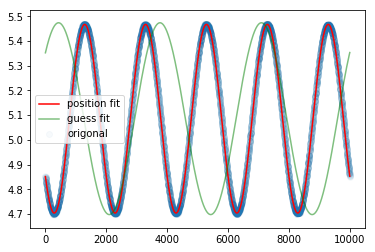

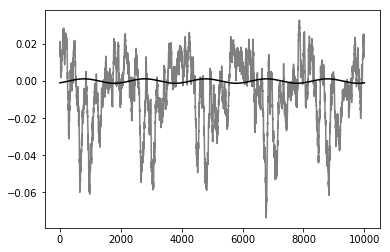

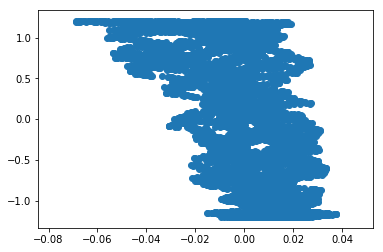

In [100]:
velocity = list()
strain_disp=list()

for file_name in file_names:
    print(file_name)
    stokes = pd.read_table(os.path.join(file_path, file_name), delimiter='\t', header=None)
    stokes.columns = 'x_volts y_volts x_strain y_strain'.split()
    
    # get the right data to work wtih
    voltage = 250
    if file_name.split('.txt')[0][-1] == 'x':
        strain_data = stokes['x_strain']
        qpd_data = stokes['x_volts']
    else:
        strain_data = stokes['y_strain']
        qpd_data = stokes['y_volts']
    times = np.asarray(range(len(strain_data)))
    
    if file_name.split('_')[-2]==5:
        p0 = [np.max(strain_data)-np.average(strain_data), 3.14192348e-03, -np.amax(strain_data[:5000]) ,  np.average(strain_data)]
    else:
        p0 = [np.max(strain_data)-np.average(strain_data), 1.88550720e-03, -np.amax(strain_data[:5000]) ,  np.average(strain_data)]

        
    # fit a sin to the stage motion
    # error form background vareince 
    
    popt, pcov = curve_fit(sinusoid, times[:5000], strain_data[:5000], p0=p0, sigma=[0.02051139]*len(strain_data[:5000]))
    print(p0)
    print(popt)
    #param_errors = fit_param_uncerts(sinusoid, popt, range(len(qpd_data)), qpd_data, [0.02051139]*len(qpd_data))
    
    # get the velocity
    vs = sinusoid_deriv(times, *popt)
    
    # plot the origonal, fit and deriv
    plt.scatter(times[:10000], strain_data[:10000], label='origonal', alpha=0.03)
    plt.plot(times[:10000], sinusoid(times, *popt)[:10000], 'r', label='position fit')
    plt.plot(times[:10000], sinusoid(times, *p0)[:10000], 'g', alpha=0.5, label='guess fit')
    plt.legend()
    plt.show()
    plt.plot(times[:10000], qpd_data[:10000], 'k', alpha=0.5, label='guess fit')
    plt.plot(times[:10000], sinusoid_deriv(times, *popt)[:10000], 'k', label='velocity')
    plt.show()

    plt.scatter(qpd_data[:10000]-np.average(qpd_data), vs[:10000]*1000)
    plt.show()
       

    # add to the lists of params
    velocity.append(vs)
    slope = linear(voltage, *x_calib)
    strain_disp.append(((1/slope)*(qpd_data-np.average(qpd_data))))
    print()
    

In [104]:
# get stokes drag
velocity=np.asarray(velocity).flatten()
strain_disp=np.asarray(strain_disp).flatten()
var_root = np.sqrt(np.var(strain_disp)/np.var(velocity))*.42/new_vars[3]
print(var_root)

5406.279794895763


In [ ]:
len(velocity)

In [ ]:
plt.plot(times, sinusoid(times, *popt), 'r', label='position fit')